In [24]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import seaborn as sns
import time
# in house functions: 
%run 'DST_fun.ipynb' # model_report() and review_vector() 

train = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col=0)
y_train = train.etoiles
X_train = train.drop("etoiles", axis = 1)
X_train = X_train[['n_avis','sentiment_norm','longueur_texte']]

test = pd.read_csv('../data/avis/test_noYC_lemma_sent_equil.csv')
y_test = test['etoiles']
X_test = test.drop("etoiles", axis =1)
X_test = X_test[['n_avis','sentiment_norm','longueur_texte']]

model_name = "SVC"

X_train.head(2)

,n_avis,sentiment_norm,longueur_texte
5529,1.0,0.804014,95
57109,1.0,0.974431,73


# 0 Modelisation de base n_avis, length

# 1. modelisation n avis, sentiment, longeur txt

train score:  0.32
              precision    recall  f1-score   support

           1       0.34      0.50      0.41       562
           2       0.39      0.15      0.22       562
           3       0.22      0.14      0.17       562
           4       0.18      0.04      0.07       562
           5       0.33      0.76      0.46       562

    accuracy                           0.32      2810
   macro avg       0.29      0.32      0.27      2810
weighted avg       0.29      0.32      0.27      2810



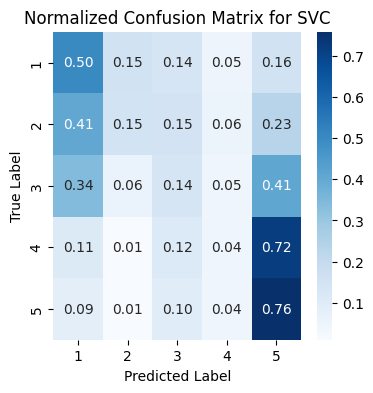

In [25]:
test_name ="SVM - n_avis, sentiment, text length"
model = svm.SVC(random_state = 7)
t0 = time.time()
model.fit(X_train, y_train)
model_report(test_name)

# 2. Grid SVM n_avis, sentiment, txt length

In [26]:
test_name ="SVM - GRID n_avis, sentiment, text length"
# definir des hyper paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

# tester les différents paramètres
t0= time.time()
model = GridSearchCV(svm.SVC(random_state = 7), param_grid, refit = True, verbose = 3)
model.fit(X_train, y_train)
print("best parameters", model.best_params_)
model_report(test_name, model_name)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.332 total time=   4.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.327 total time=   4.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.318 total time=   4.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.323 total time=   4.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.325 total time=   4.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.383 total time=   5.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.379 total time=   5.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.360 total time=   4.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.387 total time=   5.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.365 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.367 total time=   4.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

# 3. Grid SVM: text TFIDF, n_avis, sent, length

In [ ]:
test_name ="SVM - GRID text TFIDF, n_avis, sentiment, text length"
# Vectorization des avis lémmatisés
X_train = review_vector(train, ["n_avis","longueur_texte"])
X_test = review_vector(test, ["n_avis","longueur_texte"])
# definir des hyper paramètres à tester
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

# tester les différents paramètres
t0= time.time()
model = GridSearchCV(svm.SVC(random_state = 7), param_grid, refit = True, verbose = 3)
model.fit(X_train, y_train)
# reporting
model_report(test_name)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

# Recap

In [ ]:
bench = pd.read_csv(f'../reports/{model_name}_model_benchmark.csv', index_col=0)
bench[bench.model == type(model).__name__]

,model,grid search,used/best params,features,score,precision,recall,f1,time_taken_mns,run_date
0,SVC,no,baseline hyperparameters,['n_avis' 'sentiment_norm' 'longueur_texte'],0.32,0.29,0.32,0.27,0.12,2024-02-03


In [ ]:
type(model).__name__

'SVC'